In [1]:
%matplotlib inline

#Load required modules
import sys, os, argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import math
# sns.set_style('whitegrid')

### Set up seaborn appearence
mpl.rc('text', usetex = True)
sns.set_context("notebook", font_scale=1.5)
plt.rc("axes.spines", top=True, right=True)

In [2]:
# Load oncolib module
sys.path.append("/Users/melkebir/Projects/OncoSim/build/")
# sys.path.append("/Users/melkebir/Projects/OncoSim/build2/Debug")
import oncolib

# 1. Generate simulations

In [3]:
mutRateList = [0.1, 0.2, 0.4]
mutClusterCountDict = {3:0.1, 5:0.1, 7:0.2, 9:0.2, 11:0.4, 13:0.4}
sampleCountList = [1, 2, 5, 10]
# sampleCountList = [2]

## 1.1 Simulate tumors

In [ ]:
if not os.path.exists("simulate_output"):
    os.mkdir("simulate_output")

for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    out_dir = "simulate_output/n%d" % (n)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    oncolib.simulate(out_dir, {'nrSamplesPerAnatomicalSite' : 0, 'nrTrials' : 10, 
                               'desiredNrMutationClusters' : n,
                               'maxNrAnatomicalSites' : 1, 'nrSamplesPrimary' : 1,
                               'mutationRate' : M})

## 1.2 Generate samples from each simulated tree

In [ ]:
if not os.path.exists("mix_output"):
    os.mkdir("mix_output")
    
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    in_dir = "simulate_output/n%d" % (n)
    for filename in glob.glob(in_dir + "/*.tree"):
        seed = int(filename.rstrip(".tree").split("/")[-1].split("_")[-1].lstrip('seed'))
        for k in sampleCountList:
            out_filename = "mix_output/n%d_S%d_k%d.tree" % (n, seed, k)
            oncolib.mix(filename, out_filename, k, True)
            out_filename_freqs = "mix_output/n%d_S%d_k%d.tsv" % (n, seed, k)
            oncolib.tree2freqs(out_filename, out_filename_freqs)
            out_filename_precluster = "mix_output/n%d_S%d_k%d_clustered.tsv" % (n, seed, k)
            clustering_filename = "simulate_output/n%d/clustering_observed_seed%d.txt" % (n, seed)
            oncolib.precluster(out_filename_freqs, clustering_filename, out_filename_precluster)

# 2. Solve simulated instances

## 2.1 Enumerate mutation trees

First dry (only counts) then non-dry (actual trees).

In [ ]:
if not os.path.exists("enumerate_output"):
    os.mkdir("enumerate_output")

for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            if not os.path.exists(out_filename):
                print out_filename
                sys.stdout.flush()
                oncolib.enumerate(filename, out_filename, True, 1, -1, True)

In [ ]:
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("mix_output/n%d_*_k%d_clustered.tsv" % (n, k)):
            out_filename = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt"
            with open(out_filename) as f:
                f.readline()
                count = int(f.readline().split()[0])
            if count <= 10000000:
                out_filename2 = "enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + "_trees.txt"
                if not os.path.exists(out_filename2):
                    print out_filename2
                    sys.stdout.flush()
                    oncolib.enumerate(filename, out_filename2, True, 1, -1, False)

## 2.2 Compute solution statistics

In [24]:
with open("results.tsv", "w") as f:
    f.write("\t".join(["n", "seed", "k", "bound", "count", "inc"]) + "\n")
    for n in mutClusterCountDict:
        M = mutClusterCountDict[n]
        for k in sampleCountList:
            for filename in glob.glob("mix_output/n%d*_k%d_clustered.tsv" % (n, k)):
                seed = int(filename.split("_")[2][1:])
                bound = oncolib.countSpanningTrees(filename)
                inc = oncolib.getFractionOfIncomparablePairs(filename)
                
                try:
                    with open("enumerate_output/" + os.path.basename(filename).rstrip(".tsv") + ".txt") as ff:
                        ff.readline()
                        count = int(ff.readline().split()[0])

                    f.write("\t".join(map(str, [n, seed, k, bound, count, inc])) + "\n")
                except IndexError:
                    print "IndexError", filename

mix_output/n3_S12_k1_clustered.tsv
mix_output/n3_S104_k1_clustered.tsv
mix_output/n3_S39_k1_clustered.tsv
mix_output/n3_S50_k1_clustered.tsv
mix_output/n3_S129_k1_clustered.tsv
mix_output/n3_S8_k1_clustered.tsv
mix_output/n3_S119_k1_clustered.tsv
mix_output/n3_S15_k1_clustered.tsv
mix_output/n3_S2_k1_clustered.tsv
mix_output/n3_S30_k1_clustered.tsv
mix_output/n3_S12_k2_clustered.tsv
mix_output/n3_S39_k2_clustered.tsv
mix_output/n3_S104_k2_clustered.tsv
mix_output/n3_S8_k2_clustered.tsv
mix_output/n3_S129_k2_clustered.tsv
mix_output/n3_S50_k2_clustered.tsv
mix_output/n3_S30_k2_clustered.tsv
mix_output/n3_S2_k2_clustered.tsv
mix_output/n3_S15_k2_clustered.tsv
mix_output/n3_S119_k2_clustered.tsv
mix_output/n3_S12_k5_clustered.tsv
mix_output/n3_S104_k5_clustered.tsv
mix_output/n3_S39_k5_clustered.tsv
mix_output/n3_S50_k5_clustered.tsv
mix_output/n3_S129_k5_clustered.tsv
mix_output/n3_S8_k5_clustered.tsv
mix_output/n3_S119_k5_clustered.tsv
mix_output/n3_S15_k5_clustered.tsv
mix_output/n3_S3

## 2.3 Compute recall

In [5]:
if not os.path.exists("recall_output"):
    os.mkdir("recall_output")
    
for n in mutClusterCountDict:
    M = mutClusterCountDict[n]
    for k in sampleCountList:
        for filename in glob.glob("enumerate_output/n%d*_k%d_clustered_trees.txt" % (n, k)):
            seed = int(filename.split("_")[2][1:])
            out_filename = "recall_output/" + os.path.basename(filename).rstrip(".txt") + ".tsv"
            if not os.path.exists(out_filename):
                try:
                    oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename)
                except RuntimeError:
                    print "RuntimeError", out_filename

In [9]:
%%bash
if [ ! -e recall.tsv ]
then
    echo -e "n\tk\tS\tinc\tpar\tanc" > recall.tsv
    for n in {3,5,7,9,11,13}
    do
        for k in {1,2,5,10}
        do
            for f in recall_output/n${n}_*_k${k}_clustered_trees.tsv
            do
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                echo -e "$n\t$k\t$S\t$inc\t$par\t$anc" >> recall.tsv
            done
        done
    done
fi

## 2.4 SCS

In [12]:
if not os.path.exists("SCS_output"):
    os.mkdir("SCS_output")
    
n=9
for k in sampleCountList:
    for filename in glob.glob("enumerate_output/n%d_*_k%d_clustered_trees.txt" % (n, k)):
        seed = int(os.path.basename(filename).split("_")[1][1:])
        for nrCells in range(6):
            out_filename = "SCS_output/" + os.path.basename(filename)[:-20] + "_c" + str(nrCells) + ".txt"
            if not os.path.exists(out_filename):
                oncolib.filterSCS(filename, "simulate_output/n%d/T_seed%d.tree" % (n, seed), out_filename, nrCells, 0)

In [23]:
%%bash
for f in SCS_output/n9_S*_k*_c?.txt
do
    trees=$(grep edges $f | wc -l)
    ff=SCS_output/$(basename $f .txt)_prefixed.txt
    echo $trees "#trees" > $ff
    grep -v "^#" $f >> $ff
done

In [35]:
n=9
for k in sampleCountList:
    for filename in glob.glob("SCS_output/n%d_*_k%d_c?_prefixed.txt" % (n, k)):
        out_filename2 = "SCS_output/" + os.path.basename(filename).rstrip("_prefixed.txt") + "_recall.txt"
        seed = int(filename.split('_')[2][1:])
        if not os.path.exists(out_filename2):
            oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename2)

In [81]:
%%bash
if [ ! -e recall_SCS.tsv ]
then
    echo -e "n\tk\tS\tc\tinc\tpar\tanc\tcount" > recall_SCS.tsv
    n=9
    for k in {1,2,5,10}
    do
        for c in {0,1,2,3,4,5}
        do
            for f in SCS_output/n${n}_*_k${k}_c${c}_recall.txt
            do
            
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}.*$//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                count=$(cat SCS_output/n${n}_S${S}_k${k}_c${c}_prefixed.txt | head -n 1 | cut -d' ' -f1)
                echo -e "$n\t$k\t$S\t$c\t$inc\t$par\t$anc\t$count" >> recall_SCS.tsv
            done
        done
    done
fi

cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe


## 2.5 Long-Read Sequencing

In [87]:
if not os.path.exists("LRS_output"):
    os.mkdir("LRS_output")
    
n=9
for k in sampleCountList:
    for filename in glob.glob("enumerate_output/n%d_*_k%d_clustered_trees.txt" % (n, k)):
        seed = int(os.path.basename(filename).split("_")[1][1:])
        for nrPairs in range(6):
            out_filename = "LRS_output/" + os.path.basename(filename)[:-20] + "_r" + str(nrPairs) + ".txt"
            if not os.path.exists(out_filename):
                oncolib.filterLR(filename, "simulate_output/n%d/T_seed%d.tree" % (n, seed), out_filename, nrPairs, 0)

In [88]:
%%bash
for f in LRS_output/n9_S*_k*_r?.txt
do
    trees=$(grep edges $f | wc -l)
    ff=LRS_output/$(basename $f .txt)_prefixed.txt
    echo $trees "#trees" > $ff
    grep -v "^#" $f >> $ff
done

In [89]:
n=9
for k in sampleCountList:
    for filename in glob.glob("LRS_output/n%d_*_k%d_r?_prefixed.txt" % (n, k)):
        out_filename2 = "LRS_output/" + os.path.basename(filename).rstrip("_prefixed.txt") + "_recall.txt"
        seed = int(filename.split('_')[2][1:])
        if not os.path.exists(out_filename2):
            oncolib.computeRecall(filename, "simulate_output/n%d_S%d.tree" % (n, seed), out_filename2)

In [90]:
%%bash
rm recall_LRS.tsv
if [ ! -e recall_LRS.tsv ]
then
    echo -e "n\tk\tS\tr\tinc\tpar\tanc\tcount" > recall_LRS.tsv
    n=9
    for k in {1,2,5,10}
    do
        for r in {0,1,2,3,4,5}
        do
            for f in LRS_output/n${n}_*_k${k}_r${r}_recall.txt
            do
            
                S=$(echo $(basename $f _clustered_trees.tsv) | sed -e s/n${n}_S//g | sed -e s/_k${k}.*$//g)
                inc=$(datamash -H median 4 < $f | tail -n 1)
                par=$(datamash -H median 3 < $f | tail -n 1)
                anc=$(datamash -H median 2 < $f | tail -n 1)
                count=$(cat LRS_output/n${n}_S${S}_k${k}_r${r}_prefixed.txt | head -n 1 | cut -d' ' -f1)
                echo -e "$n\t$k\t$S\t$r\t$inc\t$par\t$anc\t$count" >> recall_LRS.tsv
            done
        done
    done
fi

cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe
cat: stdout: Broken pipe


## 2.6 PhyloWGS

In [103]:
%%bash
n=7
for f in mix_output/n7_*_clustered.tsv
do
    python PhyloWGS_input/convertToPhyloWGS.py $f > PhyloWGS_input/$(basename $f _clustered.tsv).phylowgs
done

In [20]:
%%bash
rm phylowgs_instances.txt
for f in PhyloWGS_output/*.txt
do
    ff=$(grep CLUSTERED $f)
    if [ -z "$ff" ]
    then
        echo $(basename $f) >> phylowgs_instances.txt
    fi
done

In [22]:
with open('phylowgs_instances.txt') as f:
    for line in f:
        line = line.rstrip(".txt\n")
        instance = '_'.join(line.split('_')[0:2])
        oncolib.summarize("enumerate_output/" + line + "_clustered_trees.txt", 
                          "PhyloWGS_output/" + line + ".txt",
                          "PhyloWGS_output/" + line + ".tsv")

# 3. Generate plots

In [10]:
df = pd.read_table("results.tsv")

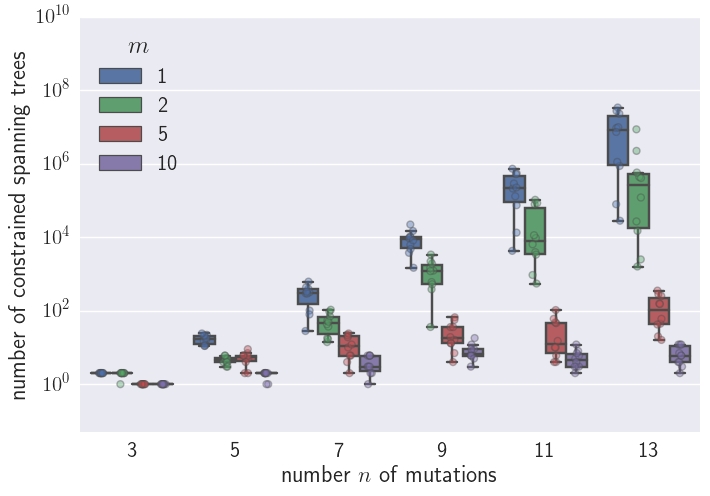

In [11]:
sns.stripplot(data=df, x="n", y="count", hue="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df, x="n", y="count", hue="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper left")
ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("number of constrained spanning trees")
plt.savefig("solutions_per_rate.pdf")

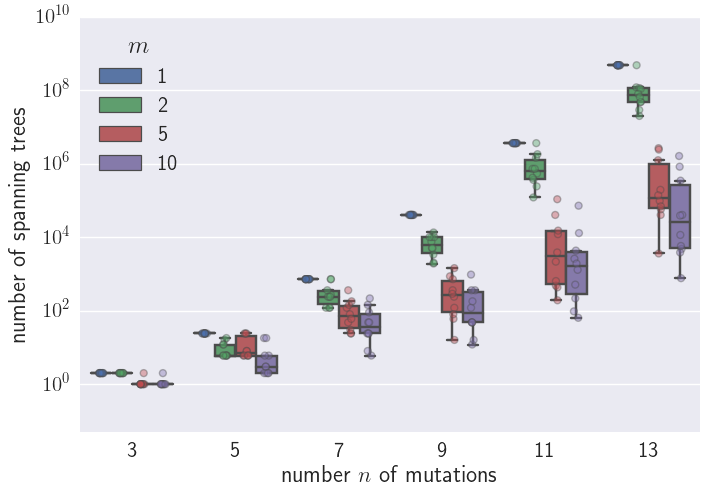

In [12]:
sns.stripplot(data=df, x="n", y="bound", hue="k", split=True, linewidth=1, alpha=.4, jitter=.1)
ax = sns.boxplot(data=df, x="n", y="bound", hue="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper left")
ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("number of spanning trees")
plt.savefig("spanning_trees_per_rate.pdf")

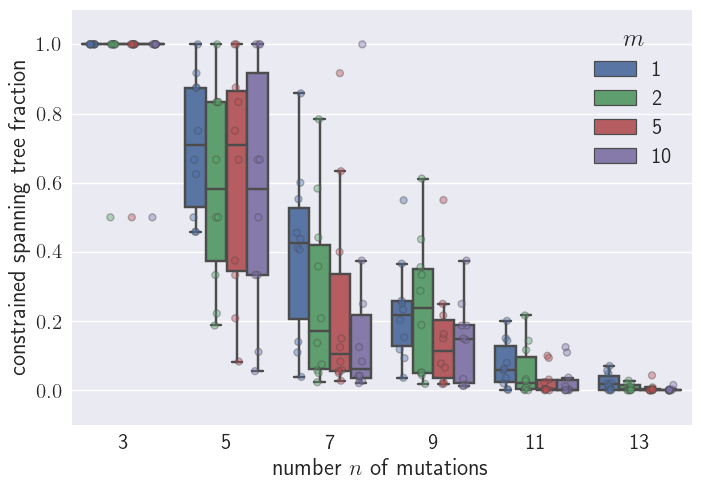

In [13]:
df['ratio'] = df['count'] / df['bound']
sns.stripplot(data=df, x="n", y="ratio", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="n", y="ratio", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4], title="$m$", loc="upper right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("constrained spanning tree fraction")
plt.savefig("num_solutions_by_num_spanning_trees.pdf")

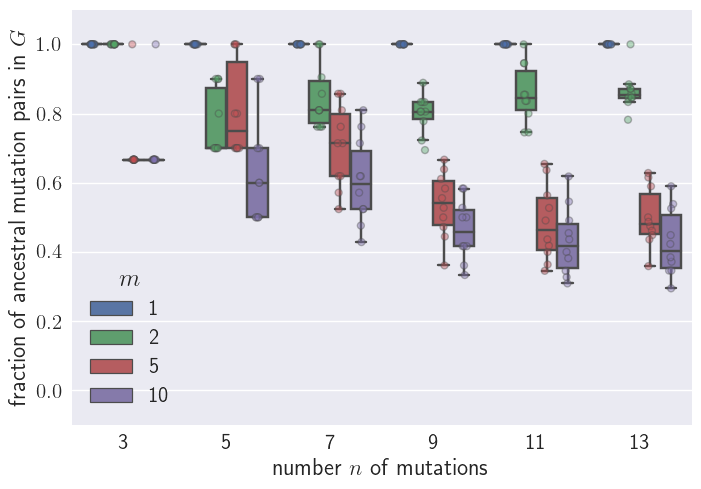

In [16]:
sns.stripplot(data=df, x="n", y="inc", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df, x="n", y="inc", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$", loc="lower left")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("fraction of ancestral mutation pairs in $G$")
plt.savefig("frac_comparable.pdf")

In [48]:
df_recall = pd.read_table('recall.tsv')

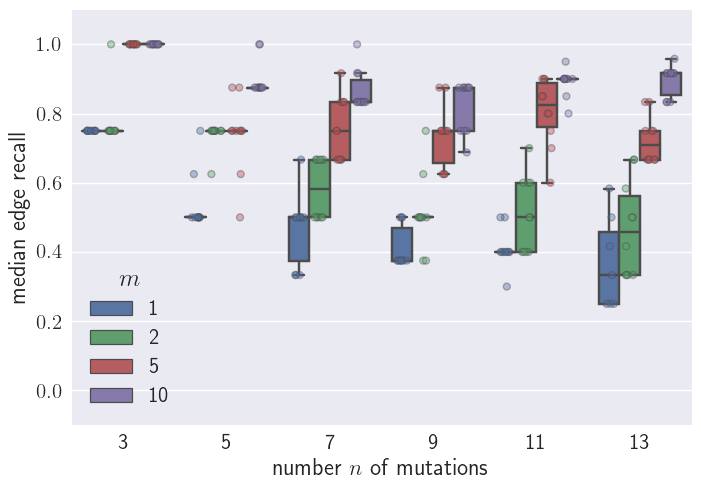

In [53]:
sns.stripplot(data=df_recall, x="n", y="par", hue="k", alpha=.4, jitter=.2, linewidth=1, split=True)
ax = sns.boxplot(data=df_recall, x="n", y="par", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$", loc="lower left")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall.pdf")

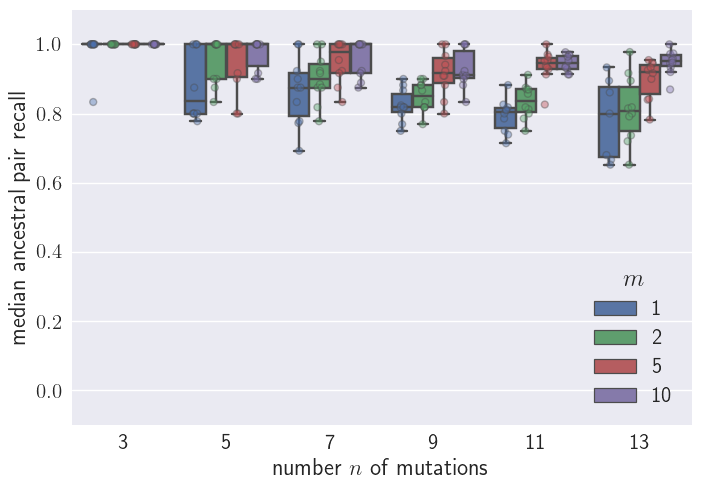

In [49]:
sns.stripplot(data=df_recall, x="n", y="anc", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df_recall, x="n", y="anc", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("median ancestral pair recall")
plt.savefig("anc_recall.pdf")

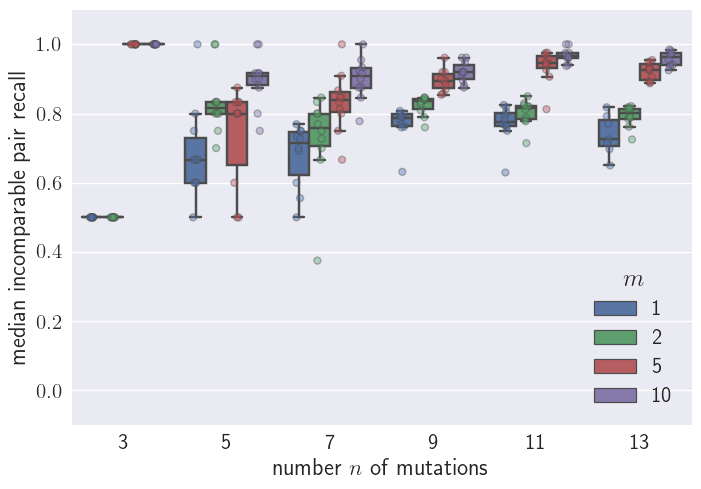

In [55]:
sns.stripplot(data=df_recall, x="n", y="inc", hue="k", alpha=.4, jitter=.1, linewidth=1, split=True)
ax = sns.boxplot(data=df_recall, x="n", y="inc", hue="k", showfliers=False)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], title="$m$")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $n$ of mutations")
ax.set_ylabel("median incomparable pair recall")
plt.savefig("inc_recall.pdf")

In [70]:
df_SCS = pd.read_table("recall_SCS.tsv")

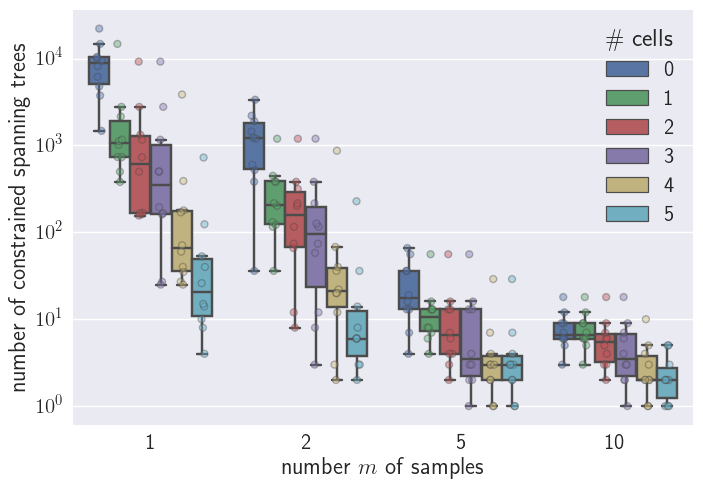

In [44]:
sns.stripplot(data=df_SCS, hue="c", y="count", x="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df_SCS, hue="c", y="count", x="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# cells", loc="upper right")
# ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("number of constrained spanning trees")
plt.savefig("solutions_SCS.pdf")

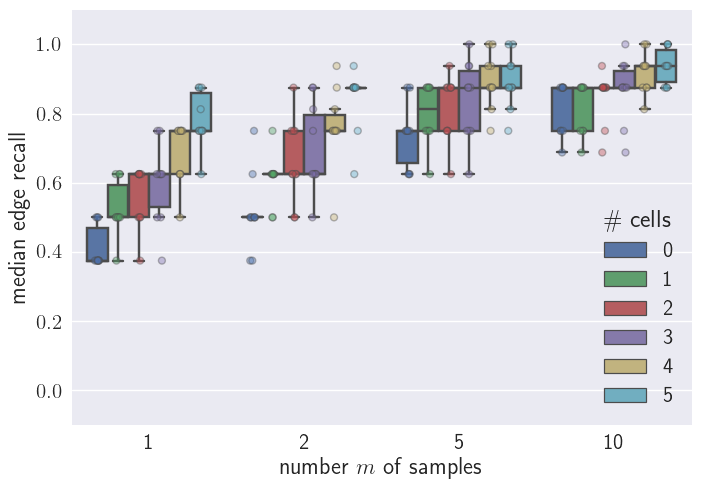

In [57]:
sns.stripplot(data=df_SCS, hue="c", y="par", x="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df_SCS, hue="c", y="par", x="k", showfliers=False)
# ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# cells", loc="lower right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall_SCS.pdf")

In [91]:
df_LRS = pd.read_table("recall_LRS.tsv")

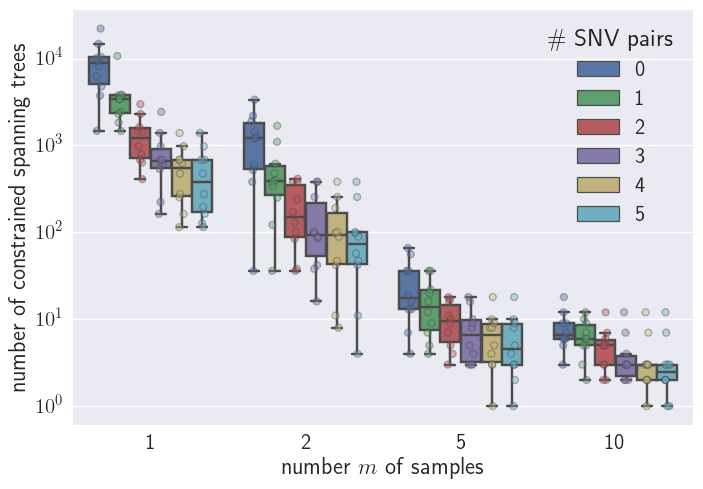

In [96]:
sns.stripplot(data=df_LRS, hue="r", y="count", x="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df_LRS, hue="r", y="count", x="k", showfliers=False)
ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# SNV pairs", loc="upper right")
# ax.set_ylim((0.05, 1e10))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("number of constrained spanning trees")
plt.savefig("solutions_LRS.pdf")

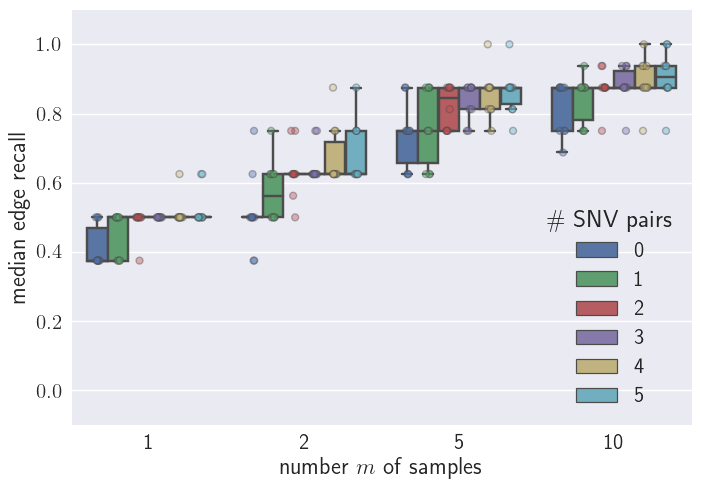

In [95]:
sns.stripplot(data=df_LRS, hue="r", y="par", x="k", alpha=.4, split=True, linewidth=1, jitter=.1)
ax = sns.boxplot(data=df_LRS, hue="r", y="par", x="k", showfliers=False)
# ax.set(yscale="log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:6], labels[0:6], title="\# SNV pairs", loc="lower right")
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel("number $m$ of samples")
ax.set_ylabel("median edge recall")
plt.savefig("edge_recall_LRS.pdf")

In [126]:
def identifySolution(filename):
    filename = os.path.basename(filename).rstrip(".txt\n")
    instance = '_'.join(line.split('_')[0:2])
    return oncolib.identifySolution("enumerate_output/" + line + "_clustered_trees.txt", 
                                    "simulate_output/" + instance + ".tree")

In [127]:
identifySolution('PhyloWGS_output/n7_S12_k1.tsv')

0

In [140]:
def plot_uniformity(filename, ax):
    df = pd.read_table(filename)
    df = df.sort_values('index')
    nrTrueSols = df['index'].max()+1
    nrSols = df['count'].sum()
    nrIncorrectSols = len(df[df['index'] < 0])
    nrCorrectSols = len(df[(df['index'] >= 0) & (df['count'] > 0)])
    df['rel_count'] = df['count'] / nrSols
    u = (nrSols / float(nrTrueSols)) / nrSols
    df.plot(x='index', y='rel_count', kind='bar', ax=ax, legend=False, 
            color=['red' if x < 0 else 'blue' for x in df['index']])
    ax.plot((nrIncorrectSols - .5, nrIncorrectSols+nrTrueSols),(u,u), ls='dashed')
#     ax.plot([nrIncorrectSols + identifySolution(filename)], [u], marker='*', markersize=25)
    ax.set_xticklabels([])
#     ax.set_ylim((-.05,1))
    ax.set_title("%d : (%d + %d) / %d" % 
                 (nrSols, nrIncorrectSols, nrCorrectSols, nrTrueSols))
    ax.set_xlabel("")

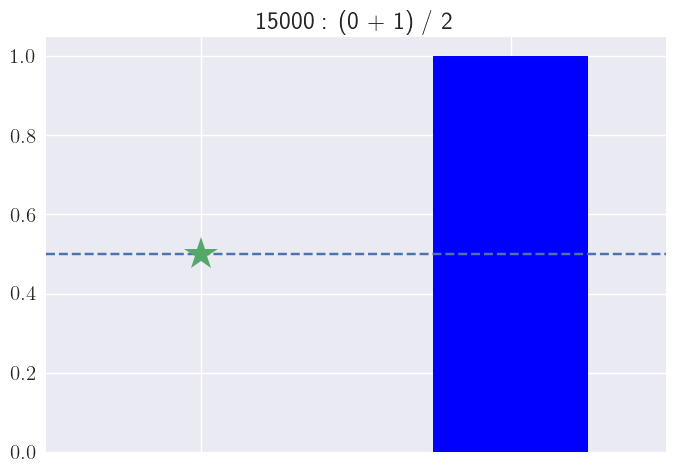

In [141]:
plot_uniformity('PhyloWGS_output/n7_S81_k10.tsv', plt.gca())

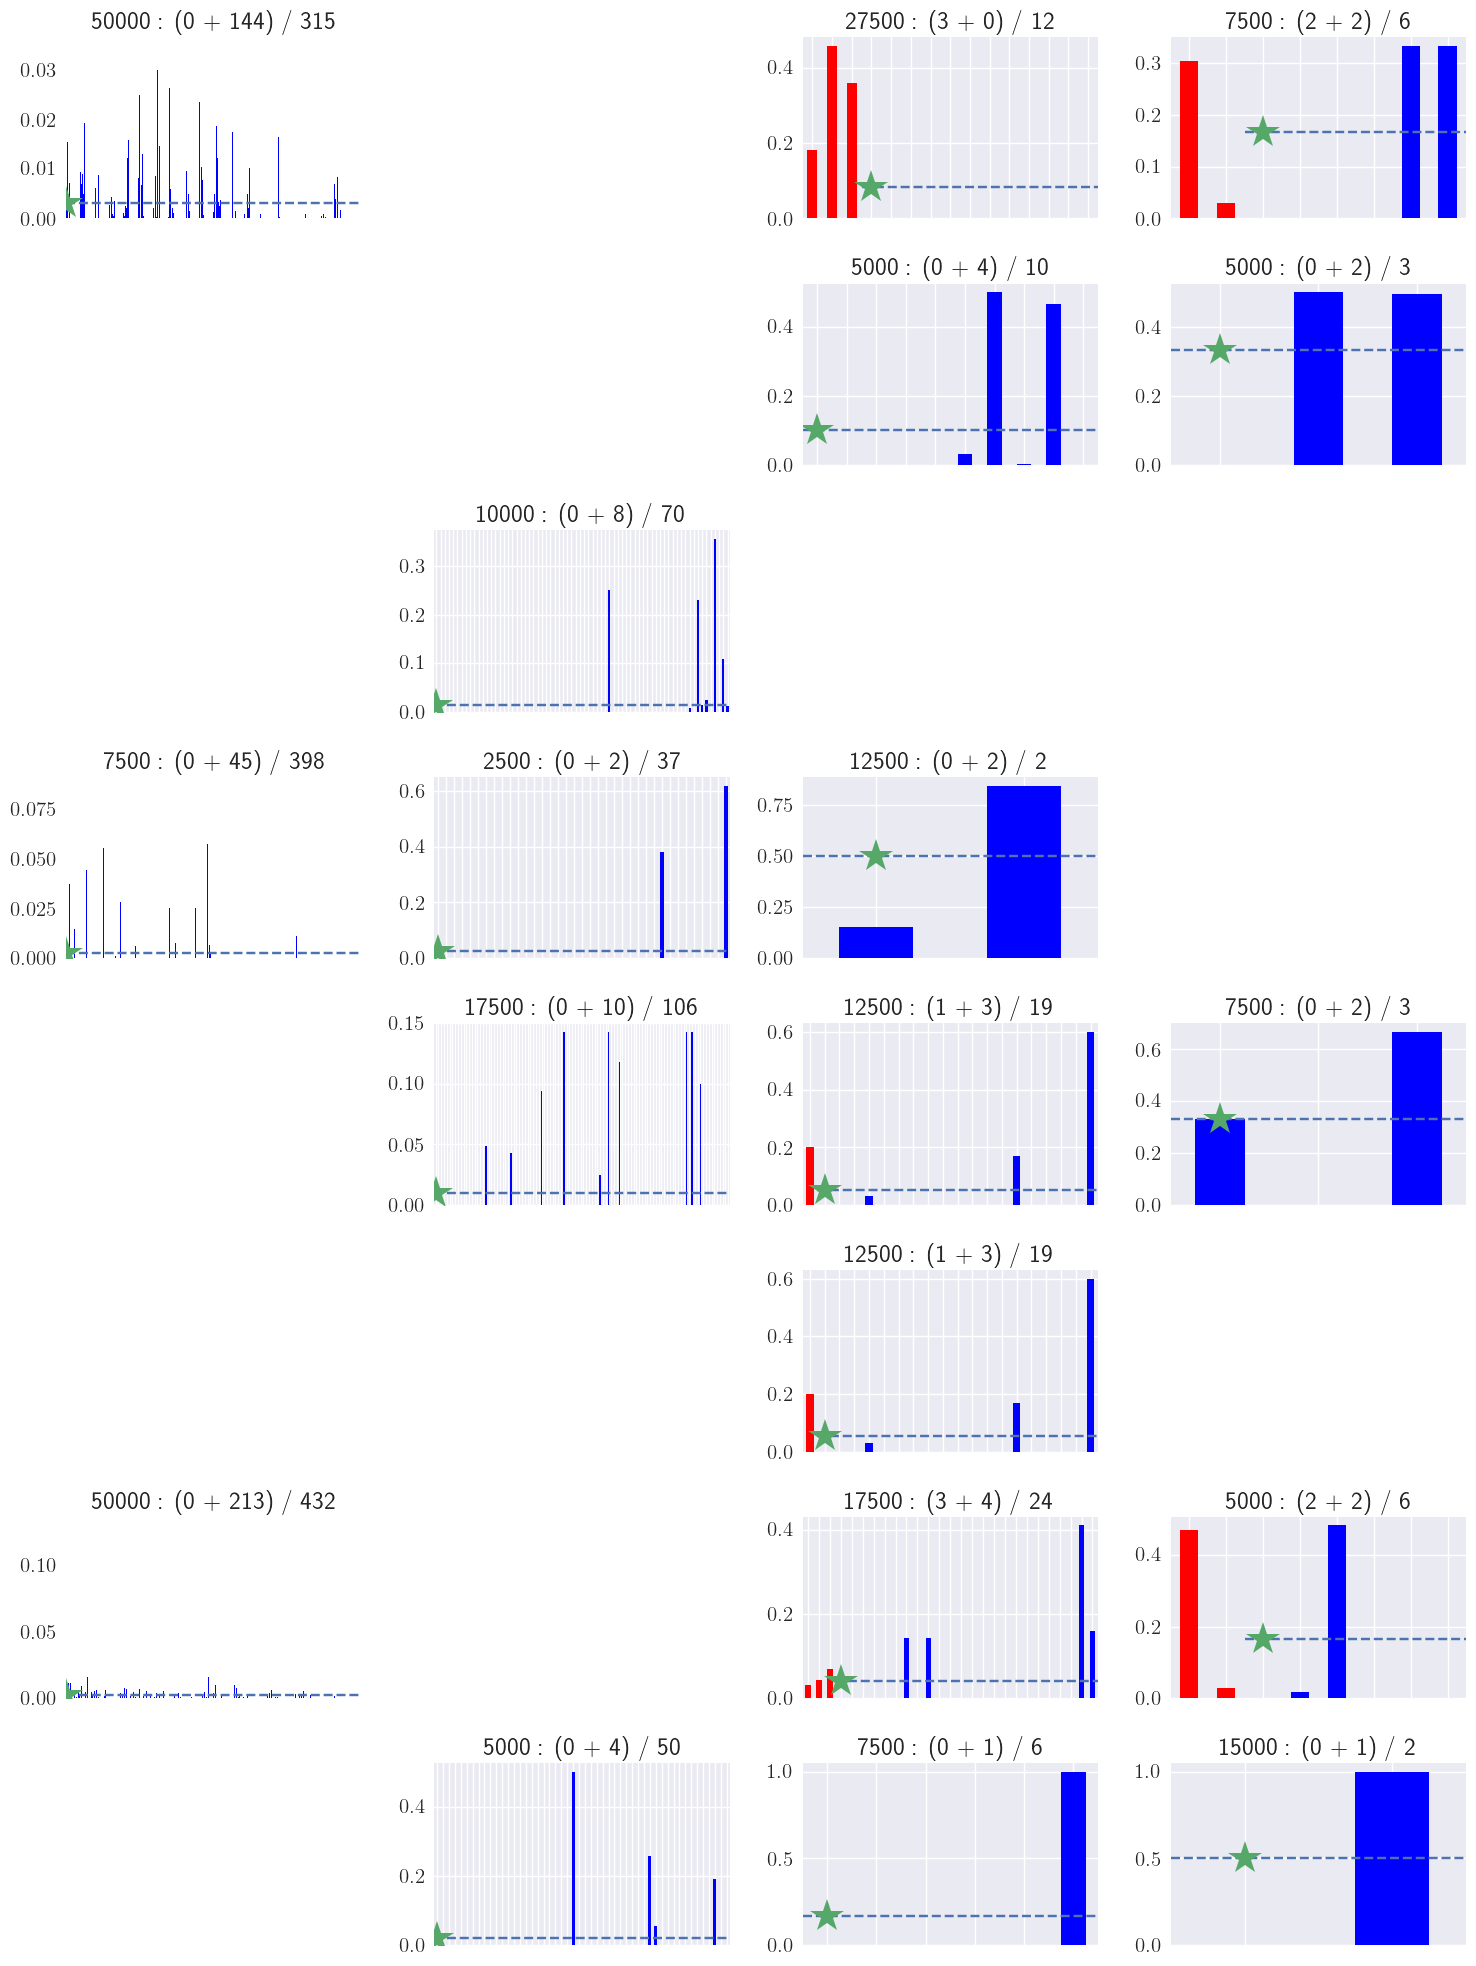

In [142]:
nrRows=8
nrCols=4
ax = plt.subplot(nrRows, nrCols, 1)
plot_uniformity('PhyloWGS_output/n7_S12_k1.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 3)
plot_uniformity('PhyloWGS_output/n7_S12_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 4)
plot_uniformity('PhyloWGS_output/n7_S12_k10.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 7)
plot_uniformity('PhyloWGS_output/n7_S23_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 8)
plot_uniformity('PhyloWGS_output/n7_S23_k10.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 10)
plot_uniformity('PhyloWGS_output/n7_S30_k2.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 13)
plot_uniformity('PhyloWGS_output/n7_S49_k1.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 14)
plot_uniformity('PhyloWGS_output/n7_S49_k2.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 15)
plot_uniformity('PhyloWGS_output/n7_S49_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 18)
plot_uniformity('PhyloWGS_output/n7_S61_k2.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 19)
plot_uniformity('PhyloWGS_output/n7_S61_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 20)
plot_uniformity('PhyloWGS_output/n7_S61_k10.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 23)
plot_uniformity('PhyloWGS_output/n7_S61_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 25)
plot_uniformity('PhyloWGS_output/n7_S7_k1.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 27)
plot_uniformity('PhyloWGS_output/n7_S7_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 28)
plot_uniformity('PhyloWGS_output/n7_S7_k10.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 30)
plot_uniformity('PhyloWGS_output/n7_S81_k2.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 31)
plot_uniformity('PhyloWGS_output/n7_S81_k5.tsv', ax)
ax = plt.subplot(nrRows, nrCols, 32)
plot_uniformity('PhyloWGS_output/n7_S81_k10.tsv', ax)
plt.gcf().set_size_inches(15, 20)
plt.tight_layout()
plt.savefig("PhyloWGS.pdf")

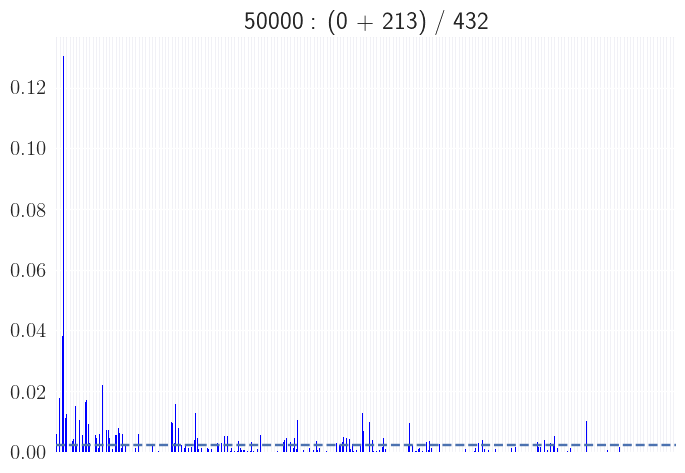

In [121]:
plot_uniformity('PhyloWGS_output/n7_S7_k1.tsv', plt.gca())

In [112]:
filename='PhyloWGS_output/n7_S61_k10.tsv'
df = pd.read_table(filename)
df = df.sort_values('index')
nrTrueSols = df['index'].max()+1
nrSols = df['count'].sum()
nrIncorrectSols = len(df[df['index'] < 0])
nrCorrectSols = len(df[(df['index'] >= 0) & (df['count'] > 0)])

In [113]:
df

,index,count
1,0,2500
2,1,0
0,2,5000
